## PCA based data distribution visualisation and classification

In [1]:
from PIL import Image
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as distance
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

Load image files from 'PIE' folder and 'own_image' folder.

The 20 subjects out of the entire data set are selected using a random number generator to ensure randomness and prevent any bias.

The images are splited into training and test sets. Out of the training set, 500 images are randomly sampled.

In [2]:
img_dir_list = ['PIE/1/*.jpg', 'PIE/4/*.jpg', 'PIE/5/*.jpg', \
               'PIE/19/*.jpg', 'PIE/21/*.jpg', 'PIE/23/*.jpg', \
               'PIE/25/*.jpg', 'PIE/29/*.jpg', 'PIE/33/*.jpg', \
               'PIE/39/*.jpg', 'PIE/40/*.jpg', 'PIE/44/*.jpg', \
               'PIE/45/*.jpg', 'PIE/46/*.jpg', 'PIE/48/*.jpg', \
               'PIE/52/*.jpg', 'PIE/57/*.jpg', 'PIE/58/*.jpg', \
               'PIE/59/*.jpg', 'PIE/67/*.jpg']
image_list = []
image_own = []
image_list_unflattened = []
train_list = []
train_own = []
test_list = []
test_own = []
label_list = []
train_label = []
test_label = []
label_own = [20] * 10

for i in range (0, 20):
    for filename in glob.glob(img_dir_list[i]):
        im = Image.open(filename)
        arr = np.array(im).flatten()
        image_list.append(arr)
        label_list.append(i)
for filename in glob.glob('own_image/*.jpg'):
    im = Image.open(filename)
    arr = np.array(im).flatten()
    image_own.append(arr)
    
label_list = np.asarray(label_list)
image_list = np.asarray(image_list)
image_own = np.asarray(image_own)
label_own = np.asarray(label_own)

train_list, test_list, train_label, test_label = train_test_split(image_list, label_list, test_size = 0.3)
train_list = np.asarray(train_list)
test_list = np.asarray(test_list)
train_label = np.asarray(train_label)
test_label = np.asarray(test_label)

train_own, test_own, train_label_own, test_label_own = train_test_split(image_own, label_own, test_size = 0.3)
train_own = np.asarray(train_own)
test_own = np.asarray(test_own)
train_label_own = np.asarray(train_label_own)
test_label_own = np.asarray(test_label_own)

random_indices = np.arange(0, train_list.shape[0])
np.random.shuffle(random_indices)
train_sample = train_list[random_indices[:500]]
train_sample_label = train_label[random_indices[:500]]

train_sample = np.concatenate((train_sample, train_own))
train_sample_label = np.concatenate((train_sample_label, train_label_own))
test_list = np.concatenate((test_list, test_own))
test_label = np.concatenate((test_label, test_label_own))

Preprocess the training and test images using StandardScaler in sklearn package

In [3]:
sc = preprocessing.StandardScaler()
train_sample_prep = sc.fit_transform(train_sample)
test_list_prep = sc.transform(test_list)

Calculate training image mean

In [4]:
train_image_mean = (np.mean(train_sample_prep, axis = 0)).astype('float')
# test_image_mean = (np.mean(test_list_prep, axis = 0)).astype('float')

#### Implementation of PCA

Compute the covariance of the difference between each image and training image mean

Use numpy package to compute eigenvalue and eigenvector. Sort the eigenvalues and eigenvectors in descending order

In [5]:
def pca (image_list):
    image_mean = train_image_mean
    image_diff = image_list - image_mean
    image_diff = np.asarray(image_diff)
    covariance = np.cov(image_diff.T)
    
    eigenvalue, eigenvector = np.linalg.eig(covariance)
    idx = eigenvalue.argsort()[::-1]
    eigenvalue = np.real(eigenvalue[idx])
    eigenvector = np.real(eigenvector[:, idx])
    eigenvalue = np.asarray(eigenvalue)
    eigenvector = np.asarray(eigenvector)
    
    return eigenvalue, eigenvector

Construct a list of eigen pairs based on eigenvalues and eigenvectors

#### Reduction of Dimensionality 

Keeping first n eigen pairs from the list of eigen pairs. 

The result is the dot product of the difference between the input image list and training image mean.

In [6]:
def get_eigen_pair(eigenvalue, eigenvector):
    eigen_pairs = [(eigenvalue[i], eigenvector[:,i]) for i in range(len(eigenvalue))]
    eigen_pairs.sort(key=lambda k: k[0], reverse = True)
    return eigen_pairs

def reduce_dim(image_list, image_mean, eigenvalue, eigenvector, dim):
    eigenpair = get_eigen_pair(eigenvalue, eigenvector)
    w = np.hstack((eigenpair[0][1][:, np.newaxis], eigenpair[1][1][:, np.newaxis]))
    if (dim > 2):
        for i in range (2, dim):
            w = np.hstack((w, eigenpair[i][1][:, np.newaxis]))
    reduce_dim_result = (image_list - image_mean).dot(w)
    return reduce_dim_result.T

Compute eigenvalue and eigenvector of training data

In [7]:
eigenvalue_train, eigenvector_train = pca(train_sample_prep)

Calculate number of features required for 95% threshold and plot the gragh

include 46 features for 95% threshold


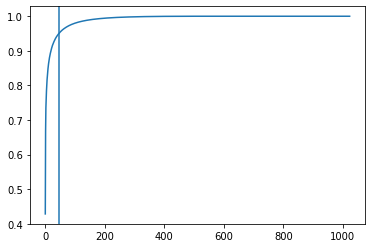

In [8]:
feature_fraction = np.cumsum(eigenvalue_train)/np.sum(eigenvalue_train)
threshold = np.argmin(np.abs(feature_fraction - 0.95))
print('include {} features for 95% threshold'.format(threshold))
plt.figure()
plt.plot(feature_fraction)
plt.axvline(threshold)
plt.show()

Reduce dimensionality of training data to 2 dimensions and 3 dimensions

In [9]:
train_2_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 2)
train_3_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 3)

Visualise projected data in 2D plot

Normal images are displayed as blue dots, data for own images are displayed as yellow triangles

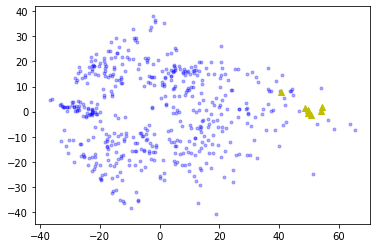

In [10]:
plt.figure()
plt.scatter(train_2_dim[0][:500], train_2_dim[1][:500], c = 'b', marker = '.', alpha = 0.3)
plt.scatter(train_2_dim[0][500:507], train_2_dim[1][500:507], c = 'y', marker = '^', alpha = 1)
plt.show()

Visualise projected data in 3D plot

Normal images are displayed as blue dots, data for own images are displayed as yellow triangles

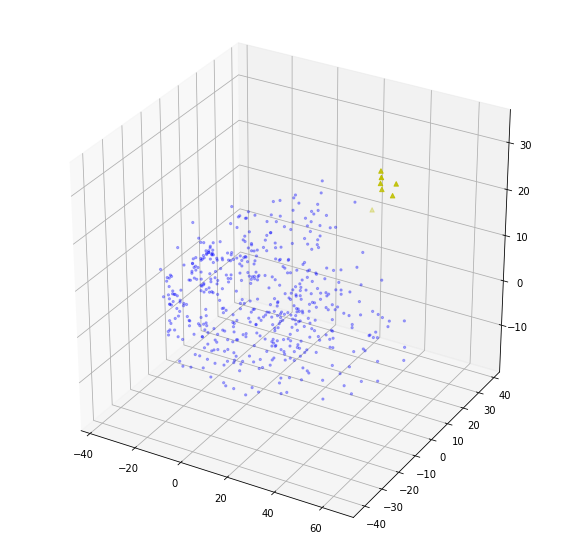

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(train_3_dim[0][:500], train_3_dim[1][:500], train_3_dim[2][:500], c = 'b', marker = '.', alpha = 0.3)
ax.scatter(train_3_dim[0][500:507], train_3_dim[1][500:507], train_3_dim[2][500:507], c = 'y', marker = '^')
plt.show()

Visualise the 3 eigenfaces

439.4879050846718
244.84196488958642
69.92904492704243


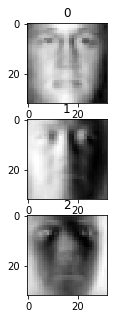

In [12]:
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
for i in range (3):
    ax[i].imshow((eigenvector_train.T[i]).reshape(32, 32), cmap = 'gray')
    ax[i].set_title(i)
    print(eigenvalue_train[i])
plt.show()

#### Implementation of K-Nearest Neighbor Classifier

First calculate euclidean distance between each image to be classified and training set images

Then calculate classification accuracy of KNN based on Euclidean distance

In [13]:
def calc_Euclidean_dist(image_list, train_list):
    Euc_dist = np.array([[distance.euclidean(image_list[idx1], train_list[idx2]) for idx2 in np.arange(len(train_list))] for idx1 in np.arange(len(image_list))])
    return (Euc_dist)

def calc_knn_accuracy (distance, label_list, train_label_list):
    error_count = 0
    for idx, distance_1D in enumerate(distance):
        dist_idx = np.argsort(distance_1D)[:1]
        if (train_label_list[dist_idx] != label_list[idx]):
            error_count += 1
    error_rate = error_count / label_list.shape[0] * 100
    return (100 - error_rate)

Reduce dimensionality of training data and test data to 40, 80 and 200 dimensions

In [14]:
train_40_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 40)
train_80_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 80)
train_200_dim = reduce_dim(train_sample_prep, train_image_mean, eigenvalue_train, eigenvector_train, 200)
test_40_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 40)
test_80_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 80)
test_200_dim = reduce_dim(test_list_prep, train_image_mean, eigenvalue_train, eigenvector_train, 200)

Calculate the classification accuracy for dimensionality equals 40

In [15]:
test_40_euc_dist = calc_Euclidean_dist(test_40_dim.T, train_40_dim.T)
test_40_knn_accuracy = calc_knn_accuracy(test_40_euc_dist[:1020], test_label[:1020], train_sample_label)
test_40_own_knn_accuracy = calc_knn_accuracy(test_40_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)

print("Dimensionality = 40")
print("Classification Accuracy on CMU PIE test images: " + str(test_40_knn_accuracy) + "%")
print("Classification Accuracy on own images: " + str(test_40_own_knn_accuracy) + "%")

Dimensionality = 40
Classification Accuracy on CMU PIE test images: 62.254901960784316%
Classification Accuracy on own images: 100.0%


Calculate the classification accuracy for dimensionality equals 80

In [16]:
test_80_euc_dist = calc_Euclidean_dist(test_80_dim.T, train_80_dim.T)
test_80_knn_accuracy = calc_knn_accuracy(test_80_euc_dist[:1020], test_label[:1020], train_sample_label)
test_80_own_knn_accuracy = calc_knn_accuracy(test_80_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)

print("Dimensionality = 80")
print("Classification Accuracy on CMU PIE test images: " + str(test_80_knn_accuracy) + "%")
print("Classification Accuracy on own images: " + str(test_80_own_knn_accuracy) + "%")

Dimensionality = 80
Classification Accuracy on CMU PIE test images: 66.07843137254902%
Classification Accuracy on own images: 100.0%


Calculate the classification accuracy for dimensionality equals 200

In [17]:
test_200_euc_dist = calc_Euclidean_dist(test_200_dim.T, train_200_dim.T)
test_200_knn_accuracy = calc_knn_accuracy(test_200_euc_dist[:1020], test_label[:1020], train_sample_label)
test_200_own_knn_accuracy = calc_knn_accuracy(test_200_euc_dist[1020:1023], test_label[1020:1023], train_sample_label)

print("Dimensionality = 200")
print("Classification Accuracy on CMU PIE test images: " + str(test_200_knn_accuracy) + "%")
print("Classification Accuracy on own images: " + str(test_200_own_knn_accuracy) + "%")

Dimensionality = 200
Classification Accuracy on CMU PIE test images: 68.13725490196079%
Classification Accuracy on own images: 100.0%
